# 🧬 Fine-Tuning a Post-trained Model on Functional BigWig Tracks Prediction (reproduce paper results)

This notebook is designed to enable the reproduction of the fine-tuning results on functional genomics tracks in the paper. In contrast to the simplified fine tuning setup in [02_fine_tuning_pretrained_model_biwig.ipynb](https://huggingface.co/spaces/InstaDeepAI/ntv3/blob/main/notebooks_tutorials/02_fine_tuning_pretrained_model_biwig.ipynb), this more complex setup is designed to mirror the internal JAX pipeline used to run the evaluations in PyTorch and using our HuggingFace models.
As in the benchmark, the notebook finetunes the post-trained Nucleotide Transformer v3 (`NTv3_650M_post`) model to predict BigWig signal tracks directly from DNA sequences. The streamlined approach leverages a post-trained NTv3 backbone as a feature extractor. A new prediction head is added to the model, which outputs single-nucleotide resolution signal values for each of the functional bigwig tracks in the NTv3 benchmark for the selected species. The notebook uses the 34 tracks for the `human` species by default, but the user can change the config to use any species from the benchmark.

**🦚 Features:**
In addition to the simplifed version, the following features are added:
- Learning rate scheduling
- Use fixed dataset regions for training
- Implement gradient accumulation for large batch sizes
- Use the best model (selected via validation Pearson) for evaluation 
- Save the latest and best models for future use

**🔦 JAX vs PyTorch:**
The values achieved by this pipeline are close (within 0.01 mean Pearson for human) to those reported in the paper. They differ slightly due to using here a PyTorch pipeline to make it easier for users, as opposed to the JAX pipeline used for the results in the paper. For most accurate performance, it is recommended to use 3x seeds and average the results, as shown in the paper.

**🚆 Training:**
To run this training, you will need a large GPU (either A100 or H100). It takes around 28 hours on an H100 with the default settings. It might be possible to improve the tuning of the number of workers to improve efficiency. Our JAX pipeline is able to complete the training in around 12 hours.

📝 Note for Google Colab users: This notebook is compatible with Colab! This notebook is designed to be run on a high-performance GPU. The default parameters can be used with a H100 with 80GB of HBM.


# 0. 📦 Imports dependencies

In [1]:
# Login to HuggingFace (required for gated models)
from huggingface_hub import login
login()

In [2]:
# Install dependencies
!pip install pyfaidx pyBigWig torchmetrics transformers

In [3]:
import bisect
import functools
from typing import List, Dict, Callable, Any, cast
import os
import fnmatch
from pathlib import Path
from huggingface_hub import HfApi, snapshot_download

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from transformers import AutoConfig, AutoModel, AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyBigWig
from pyfaidx import Fasta
from torchmetrics import PearsonCorrCoef
from tqdm import tqdm

# 1. ⚙️ Configuration

## Configuration Parameters

### Model
- **`model_name`**: HuggingFace model name/identifier for the pretrained backbone model
- **`best_model_checkpoint_path`**: Path to use when saving the best model checkpoint

### Data
- **`hf_repo_id`**: HuggingFace dataset repository ID containing the benchmark data
- **`species`**: Species name (e.g., "human", "tomato") to select bigwig data from the benchmark dataset
- **`data_cache_dir`**: Directory where downloaded data files (FASTA, bigWig) will be stored
- **`sequence_length`**: Length of input sequences in base pairs (bp)
- **`keep_target_center_fraction`**: Fraction of center sequence to keep for target prediction (crops edges to focus on center)
- **`train_overlap`**: Fraction of sequence that overlaps between unique training samples

### Training
- **`mini_batch_size`**: Number of samples per mini batch on the device
- **`num_accumulation_gradient`**: Number of gradient accumulation steps
- **`num_steps_training`**: Total number of training steps (each step has an effective batch size of `mini_batch_size * num_accumulation_gradient`)
- **`initial_learning_rate`**: Initial learning rate for optimizer
- **`num_steps_warmup`**: Number of warmup steps (3% of `num_steps_training`)
- **`end_learning_rate`**: Peak learning rate after warmup
- **`weight_decay`**: L2 regularization coefficient for optimizer
- **`log_every_n_steps`**: Log training metrics every N steps

### Validation
- **`validate_every_n_steps`**: Run validation every N steps
- **`num_validation_samples`**: Number of samples to use for each validation 

### General
- **`seed`**: Random seed for reproducibility
- **`device`**: Device to run training on ("cuda" or "cpu")
- **`num_workers`**: Number of worker processes for DataLoader (0 = single-threaded)

NOTE: the default parameters will finetune the model on the human dataset, to finetune on the tomato dataset, set the 'species_name' to 'tomato' in the config. You can also update the config parameters regarding the number of training and warmup tokens based on the species genome size, as done in our benchmark (see paper details), although this is not neccessery to achieve top performance results.

In [4]:
config = {
     # Model
    "model_name": "InstaDeepAI/NTv3_650M_post",
    "best_model_checkpoint_path": "best_model_checkpoint.pth",
    
    # Data
    "hf_repo_id": "InstaDeepAI/NTv3_benchmark_dataset",
    "species_name": "human", # Select the species to train on, i.e. "tomato"
    "data_cache_dir": "./data",
    "sequence_length": 32_768,
    "keep_target_center_fraction": 0.375,
    "train_overlap": 0.999,
    
    # Training
    "mini_batch_size": 4,
    "num_accumulation_gradient": 8,  # For an effective batch size of 32
    "num_steps_training": 19932, # Calculated to provide ~20.9B tokens
    "weight_decay": 0.01,
    "initial_learning_rate": 1e-5,
    "num_steps_warmup": 598,  # Calculated as 3% of 19932 steps
    "end_learning_rate": 5e-5,  
    "log_every_n_steps": 50,
    
    # Validation
    "validate_every_n_steps": 500, 
    "num_validation_samples": 1000,

    # General
    "seed": 0,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "num_workers": 16,
}

# Set random seed
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

# Set device
device = torch.device(config["device"])
print(f"Using device: {device}")

Using device: cuda


# 2. 📥 Genome & Tracks Data Download

Download the reference genome FASTA file and BigWig signal tracks from public repositories. These files contain the genomic sequences and experimental signal data (e.g., ChIP-seq, ATAC-seq) that we'll use for training.

In [ ]:
def prepare_genomics_inputs(
    species: str,
    data_cache_dir: str | Path = "data",
    hf_repo_id: str = "InstaDeepAI/NTv3_benchmark_dataset",
) -> tuple[str, list[str], list[str], pd.DataFrame, pd.DataFrame]:
    """
    Downloads:
      1) FASTA from HF dataset under: <species>/genome.fasta
      2) BigWigs from HF dataset under: <species>/functional_tracks/**
         (filtered by bigwig_file_ids if provided)
      3) Splits from HF dataset under: <species>/splits.bed
      4) Metadata from HF dataset under: benchmark_metadata.tsv
    
    Args:
        species: Species name (e.g., "human", "arabidopsis")
        data_cache_dir: Directory where downloaded data files will be stored
        hf_repo_id: HuggingFace dataset repository ID
    
    Returns:
      (fasta_path, bigwig_path_list, bigwig_file_ids)
    """
    cache = Path(data_cache_dir).expanduser().resolve()
    cache.mkdir(parents=True, exist_ok=True)
    
    # --- Download metadata + <species> files (FASTA, BigWigs, Splits) ---
    metadata_file = "benchmark_metadata.tsv"
    download_patterns = [metadata_file, f"{species}/genome.fasta", f"{species}/splits.bed"]
    
    # Download all BigWig files
    download_patterns.append(f"{species}/functional_tracks/*.bigwig")
    local_dir = Path(
        snapshot_download(
            repo_id=hf_repo_id,
            repo_type="dataset",
            allow_patterns=download_patterns,
            local_dir=str(cache),
        )
    )
    
    # --- Organize outputs ---
    # FASTA file
    fasta_path_repo = f"{species}/genome.fasta"
    fasta_path = str(local_dir / fasta_path_repo)
    
    # BigWig files - use downloaded files directly
    bigwig_dir = local_dir / species / "functional_tracks"
    
    # Find all downloaded BigWig files
    bigwig_paths = [str(bigwig_file) for bigwig_file in bigwig_dir.glob("*.bigwig")]
    bigwig_ids = [bigwig_file.stem for bigwig_file in bigwig_dir.glob("*.bigwig")]         

    # Data splits file
    splits_path_repo = f"{species}/splits.bed"
    splits_path = local_dir / splits_path_repo

    splits_df = pd.read_csv(
        splits_path, 
        sep="\t", 
        header=None, 
        names=["chr_name", "start", "end", "split"],
        dtype={"chr_name": str, "start": int, "end": int, "split": str},
    )
    
    # Metadata file
    metadata_path = local_dir / metadata_file
    metadata_df = pd.read_csv(metadata_path, sep="\t")

    # Filter and order metadata 
    metadata_df = metadata_df[metadata_df["species_common_name"] == species].reset_index(drop=True)
    metadata_df = metadata_df.set_index("file_id").loc[bigwig_ids].reset_index()

    return fasta_path, bigwig_paths, bigwig_ids, splits_df, metadata_df

In [6]:
os.makedirs(config["data_cache_dir"], exist_ok=True)

# Download all species files + load the splits, and metadata
(
    fasta_path, 
    bigwig_paths, 
    bigwig_ids, 
    species_splits_df,
    metadata_df 
) = prepare_genomics_inputs(
    config["species_name"], 
    config["data_cache_dir"], 
    config["hf_repo_id"]
)

Fetching 37 files:   0%|          | 0/37 [00:00<?, ?it/s]

human/functional_tracks/ENCSR154HRN_M.bi(…):   0%|          | 0.00/40.6M [00:00<?, ?B/s]

human/functional_tracks/ENCSR114HGS_M.bi(…):   0%|          | 0.00/69.3M [00:00<?, ?B/s]

human/functional_tracks/ENCSR114HGS_P.bi(…):   0%|          | 0.00/71.0M [00:00<?, ?B/s]

human/functional_tracks/ENCSR100LIJ_M.bi(…):   0%|          | 0.00/24.7M [00:00<?, ?B/s]

human/functional_tracks/ENCSR100LIJ_P.bi(…):   0%|          | 0.00/25.0M [00:00<?, ?B/s]

benchmark_metadata.tsv:   0%|          | 0.00/8.13k [00:00<?, ?B/s]

human/functional_tracks/ENCSR046BCI_P.bi(…):   0%|          | 0.00/15.8M [00:00<?, ?B/s]

human/functional_tracks/ENCSR046BCI_M.bi(…):   0%|          | 0.00/20.5M [00:00<?, ?B/s]

human/functional_tracks/ENCSR154HRN_P.bi(…):   0%|          | 0.00/44.0M [00:00<?, ?B/s]

human/functional_tracks/ENCSR249ROI_P.bi(…):   0%|          | 0.00/105M [00:00<?, ?B/s]

human/functional_tracks/ENCSR321PWZ_M.bi(…):   0%|          | 0.00/35.1M [00:00<?, ?B/s]

human/functional_tracks/ENCSR249ROI_M.bi(…):   0%|          | 0.00/99.6M [00:00<?, ?B/s]

human/functional_tracks/ENCSR321PWZ_P.bi(…):   0%|          | 0.00/36.3M [00:00<?, ?B/s]

human/functional_tracks/ENCSR325NFE.bigw(…):   0%|          | 0.00/5.67G [00:00<?, ?B/s]

human/functional_tracks/ENCSR410DWV.bigw(…):   0%|          | 0.00/2.46G [00:00<?, ?B/s]

human/functional_tracks/ENCSR484LTQ_M.bi(…):   0%|          | 0.00/14.7M [00:00<?, ?B/s]

human/functional_tracks/ENCSR484LTQ_P.bi(…):   0%|          | 0.00/15.4M [00:00<?, ?B/s]

human/functional_tracks/ENCSR487QSB.bigw(…):   0%|          | 0.00/1.84G [00:00<?, ?B/s]

human/functional_tracks/ENCSR527JGN_P.bi(…):   0%|          | 0.00/315M [00:00<?, ?B/s]

human/functional_tracks/ENCSR527JGN_M.bi(…):   0%|          | 0.00/305M [00:00<?, ?B/s]

human/functional_tracks/ENCSR619DQO_M.bi(…):   0%|          | 0.00/127M [00:00<?, ?B/s]

human/functional_tracks/ENCSR619DQO_P.bi(…):   0%|          | 0.00/134M [00:00<?, ?B/s]

human/functional_tracks/ENCSR628PLS.bigw(…):   0%|          | 0.00/902M [00:00<?, ?B/s]

human/functional_tracks/ENCSR682BFG.bigw(…):   0%|          | 0.00/2.45G [00:00<?, ?B/s]

human/functional_tracks/ENCSR701YIC.bigw(…):   0%|          | 0.00/977M [00:00<?, ?B/s]

human/functional_tracks/ENCSR754DRC.bigw(…):   0%|          | 0.00/2.64G [00:00<?, ?B/s]

human/functional_tracks/ENCSR799DGV_M.bi(…):   0%|          | 0.00/25.4M [00:00<?, ?B/s]

human/functional_tracks/ENCSR799DGV_P.bi(…):   0%|          | 0.00/27.8M [00:00<?, ?B/s]

human/functional_tracks/ENCSR814RGG.bigw(…):   0%|          | 0.00/2.63G [00:00<?, ?B/s]

human/functional_tracks/ENCSR862QCH_M.bi(…):   0%|          | 0.00/18.3M [00:00<?, ?B/s]

human/functional_tracks/ENCSR862QCH_P.bi(…):   0%|          | 0.00/19.2M [00:00<?, ?B/s]

human/functional_tracks/ENCSR863PSM.bigw(…):   0%|          | 0.00/2.45G [00:00<?, ?B/s]

human/functional_tracks/ENCSR935RNW_P.bi(…):   0%|          | 0.00/28.2M [00:00<?, ?B/s]

human/functional_tracks/ENCSR935RNW_M.bi(…):   0%|          | 0.00/27.8M [00:00<?, ?B/s]

human/functional_tracks/ENCSR962OTG.bigw(…):   0%|          | 0.00/2.22G [00:00<?, ?B/s]

human/genome.fasta:   0%|          | 0.00/3.27G [00:00<?, ?B/s]

splits.bed:   0%|          | 0.00/9.95k [00:00<?, ?B/s]

# 3. 🧠 Model and tokenizer setup
 
In this section, we set up the model and tokenizer. 
 
Our approach uses any suitable pretrained backbone from HuggingFace Transformers (for example, `InstaDeepAI/ntv3_650M_pre`),
which is then extended with an additional linear head. 
 
This linear head is trained for regression on a set of genomic tracks, 
allowing the model to make predictions for each track at single nucleotide resolution.
 
The following code wraps the HuggingFace model together with this regression head for the end-to-end task.


In [7]:
def crop_center(x: np.ndarray, keep_target_center_fraction: float = 0.375) -> np.ndarray:
    """Crop the central sequence-length fraction for arrays of size (..., seq_len, num_tracks)"""
    seq_len = x.shape[-2]
    target_offset = int(seq_len * (1 - keep_target_center_fraction) // 2)
    target_length = seq_len - 2 * target_offset
    return x[..., target_offset:target_offset + target_length, :]


class LinearHead(nn.Module):
    """A linear head that predicts one scalar value per track."""
    def __init__(self, embed_dim: int, num_labels: int):
        super().__init__()
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_labels)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer_norm(x)
        x = self.head(x)
        x = F.softplus(x)  # Ensure positive values
        return x


class HFModelWithHead(nn.Module):
    """Simple model wrapper: HF backbone + bigwig head."""
    
    def __init__(
        self,
        model_name: str,
        bigwig_track_names: List[str],
        species_str: str,
        keep_target_center_fraction: float = 0.375,
    ):
        super().__init__()
        
        # Load base model config and model
        self.config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
        ntv3_base_model = AutoModel.from_pretrained(
            model_name, 
            trust_remote_code=True,
            config=self.config,
        )

        # Extract the discrete conditioned model (i.e. remove the heads) for finetuning
        discrete_conditioned_model = type(ntv3_base_model.core).__bases__[0]
        self.core = discrete_conditioned_model(self.config) # follows name covention
        # Load pre-trained weights (strict=False because we don't load the heads)
        self.load_state_dict(ntv3_base_model.state_dict(), strict=False) 

        self.supported_species = self.config.bigwigs_per_species.keys()
        if species_str in self.config.species_to_token_id:
            species_ids = self.config.species_to_token_id[species_str]
            self.species_ids = torch.LongTensor([species_ids])
            print(f"Using species: {species_str} with ids: {self.species_ids}")
        else:
            # Mask token id
            print(f"{species_str} not in supported species, using mask token id")
            self.species_ids = torch.LongTensor([2])

        self.keep_target_center_fraction = keep_target_center_fraction

        # Bigwig head (NTv3 outputs at single-nucleotide resolution)
        self.bigwig_head = LinearHead(self.config.embed_dim, len(bigwig_track_names))
        self.model_name = model_name
    
    def forward(self, tokens: torch.Tensor, **kwargs) -> Dict[str, torch.Tensor]:
        # Prepare the species tokens
        species_tokens = torch.repeat_interleave(self.species_ids, tokens.shape[0])
        species_tokens = species_tokens.to(tokens.device)

        # Forward through core
        outputs = self.core(tokens, [species_tokens], output_hidden_states=True)
        embedding = outputs["hidden_states"][-1]
        
        # Crop to center fraction
        if self.keep_target_center_fraction < 1.0:
            embedding = crop_center(embedding, self.keep_target_center_fraction)
        
        # Predict bigwig tracks
        bigwig_logits = self.bigwig_head(embedding)
        
        return {"bigwig_tracks_logits": bigwig_logits}

In [8]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(config["model_name"], trust_remote_code=True)

# Create model
model = HFModelWithHead(
    model_name=config["model_name"],
    bigwig_track_names=bigwig_ids,
    species_str=config["species_name"],
    keep_target_center_fraction=config["keep_target_center_fraction"],
)
model = model.to(device)
model = torch.compile(model)
model.train()

print(f"Model loaded: {config['model_name']}")
print(f"Number of bigwig tracks: {len(bigwig_ids)}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

tokenization_ntv3.py:   0%|          | 0.00/7.85k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/ntv3_base_model:
- tokenization_ntv3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/149 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/339k [00:00<?, ?B/s]

configuration_ntv3_posttrained.py:   0%|          | 0.00/4.70k [00:00<?, ?B/s]

configuration_ntv3_pretrained.py:   0%|          | 0.00/8.09k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/ntv3_base_model:
- configuration_ntv3_pretrained.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/ntv3_base_model:
- configuration_ntv3_posttrained.py
- configuration_ntv3_pretrained.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_ntv3_posttrained.py:   0%|          | 0.00/46.8k [00:00<?, ?B/s]

modeling_ntv3_pretrained.py:   0%|          | 0.00/35.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/ntv3_base_model:
- modeling_ntv3_pretrained.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/ntv3_base_model:
- modeling_ntv3_posttrained.py
- modeling_ntv3_pretrained.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
2026-01-08 12:28:36.519397: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-08 12:28:36.533091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable

model.safetensors:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

Using species: human with ids: tensor([27])
Model loaded: InstaDeepAI/NTv3_650M_post
Number of bigwig tracks: 34
Model parameters: 679,842,582


# 4. 🔄 Data loading

Create PyTorch datasets and data loaders that efficiently sample random genomic windows from the reference genome and extract corresponding BigWig signal values. The dataset handles sequence tokenization, target scaling, and chromosome-based train/val/test splits.

In [9]:
# Utility function to sample regions for a total length
def _sample_regions_for_a_total_length(
    regions: list[tuple[str, int, int]],
    total_length_needed: int,
    seed: int = 0,
) -> list[tuple[str, int, int]]:
    """
    Sample fixed regions for a total length.
    """
    # For each region, sample a window until we have total_length_needed
    sampled_regions = []
    rng = np.random.RandomState(seed)
    accumulated_length = 0

    for _, (chr_name, start, end) in enumerate(regions):
        region_length = end - start
        remaining_length_needed = total_length_needed - accumulated_length

        if region_length >= remaining_length_needed:
            # Sample a random start position for the window
            max_start = region_length - remaining_length_needed
            if max_start > 0:
                window_start_offset = rng.randint(0, max_start + 1)
            else:
                window_start_offset = 0

            window_start = start + window_start_offset
            window_end = start + window_start_offset + remaining_length_needed

            sampled_regions.append((chr_name, window_start, window_end))
            accumulated_length += remaining_length_needed
            print(
                f"Sampled window from {chr_name}:{start}-{end} -> "
                f"{chr_name}:{window_start}-{window_end} "
            )
            break  # Stop after getting enough length
        else:
            # Add this smaller region and continue accumulating
            sampled_regions.append((chr_name, start, end))
            accumulated_length += region_length
            print(f"Added region {chr_name}:{start}-{end}, {accumulated_length=}")

        # Check if we have enough accumulated length
        if accumulated_length >= total_length_needed:
            print(f"Sufficient length ({accumulated_length} >= {total_length_needed})")
            break

    print(f"Sampled {len(sampled_regions)=} with total {accumulated_length=}")

    return sampled_regions


In [10]:
# Process-local cache for file handles (one per worker process)
# This allows safe multi-worker DataLoader usage
_fasta_cache = {}  # Maps (process_id, file_path) -> Fasta handle
_bigwig_cache = {}  # Maps (process_id, file_path) -> pyBigWig handle


def _get_fasta_handle(fasta_path: str) -> Fasta:
    """Get or create a FASTA file handle for the current process."""
    process_id = os.getpid()
    abs_path = str(Path(fasta_path).resolve())
    cache_key = (process_id, abs_path)
    
    if cache_key not in _fasta_cache:
        _fasta_cache[cache_key] = Fasta(abs_path, as_raw=True, sequence_always_upper=True)
    
    return _fasta_cache[cache_key]


def _get_bigwig_handle(bigwig_path: str) -> pyBigWig.pyBigWig:
    """Get or create a BigWig file handle for the current process."""
    process_id = os.getpid()
    abs_path = str(Path(bigwig_path).resolve())
    cache_key = (process_id, abs_path)
    
    if cache_key not in _bigwig_cache:
        # Check if file exists before trying to open
        if not Path(abs_path).exists():
            raise FileNotFoundError(
                f"BigWig file not found: {abs_path}\n"
                f"Original path: {bigwig_path}\n"
                f"Current working directory: {os.getcwd()}"
            )
        
        try:
            _bigwig_cache[cache_key] = pyBigWig.open(abs_path)
        except Exception as e:
            raise RuntimeError(
                f"Failed to open BigWig file: {abs_path} with error: {str(e)}\n"
                f"File exists: {Path(abs_path).exists()}\n"
                f"File size: {Path(abs_path).stat().st_size if Path(abs_path).exists() else 'N/A'} bytes"
            ) from e
    
    return _bigwig_cache[cache_key]


class GenomeBigWigDataset(Dataset):
    """
    A PyTorch dataset to access a reference genome and bigwig tracks. The dataset is 
    compatible with multi-worker DataLoaders (using process-local file handles and lazy 
    loading). For each sample, a random genomic region is picked from the specified split,
    and a random window of length `sequence_length` within that region is returned.
    """

    def __init__(
        self,
        fasta_path: str,
        bigwig_path_list: list[str],
        chrom_regions: pd.DataFrame,
        split: str,
        sequence_length: int,
        tokenizer: AutoTokenizer,
        transform_fn: Callable[[torch.Tensor], torch.Tensor],
        overlap: float = 0.0,
        keep_target_center_fraction: float = 1.0,
        limit_num_samples: int | None = None,
    ):
        super().__init__()

        # Store paths instead of opening files immediately (for multi-worker compatibility)
        self.fasta_path = fasta_path
        self.bigwig_path_list = bigwig_path_list
        self.sequence_length = sequence_length
        self.tokenizer = tokenizer
        self.transform_fn = transform_fn
        self.keep_target_center_fraction = keep_target_center_fraction
        self.chrom_regions = chrom_regions
        self.stride = int((1 - overlap) * sequence_length)

        # Filter regions by split
        split_regions = self.chrom_regions[self.chrom_regions["split"] == split].copy()
        region_list = [
            (row.chr_name, row.start, row.end) for _, row in split_regions.iterrows()
        ]
        if limit_num_samples is not None:
            length_required = limit_num_samples * self.sequence_length
            region_list = _sample_regions_for_a_total_length(region_list, length_required)
        
        # Build an index structure for efficient sequence access across genomic regions
        self.chromosome_info, self._cumulative_starts, self.num_samples = (
            self._process_regions(region_list)
        )

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Select the chromosome for the given index using binary search
        chromosome_idx = bisect.bisect_right(self._cumulative_starts, idx) - 1

        # Explicitly cast types from dictionary of chromosome information
        chrom: str = cast(str, self.chromosome_info[chromosome_idx]["chr_name"])
        region_start: int = cast(int, self.chromosome_info[chromosome_idx]["region_start_offset"])

        # Calculate the index of the sample *within* the selected chromosome region
        index_within_region = idx - self._cumulative_starts[chromosome_idx]

        # Calculate 0-based start and end for the specific sample in genome coordinates
        start = region_start + index_within_region * self.stride
        end = start + self.sequence_length

        # Sequence - get FASTA handle lazily (cached per worker process)
        fasta = _get_fasta_handle(self.fasta_path)
        seq = fasta[chrom][start:end]  # string slice
        # Tokenize with padding and truncation to ensure consistent lengths for batching
        tokenized = self.tokenizer(
            seq,
            padding="max_length",
            truncation=True,
            max_length=self.sequence_length,
            return_tensors="pt",
        )
        tokens = tokenized["input_ids"][0]  # Shape: (max_length,)

        # Signal from bigWig tracks (numpy array) -> torch tensor
        # Get BigWig handles lazily (cached per worker process)
        bigwig_targets = np.array([
            _get_bigwig_handle(bw_path).values(chrom, start, end, numpy=True)
            for bw_path in self.bigwig_path_list
        ])  # shape (num_tracks, seq_len)
        # Transpose to (seq_len, num_tracks)
        bigwig_targets = bigwig_targets.T
        # pyBigWig returns NaN where no data; turn NaN into 0
        bigwig_targets = torch.tensor(bigwig_targets, dtype=torch.float32)
        bigwig_targets = torch.nan_to_num(bigwig_targets, nan=0.0)
        
        # Crop targets to center fraction
        if self.keep_target_center_fraction < 1.0:
            bigwig_targets = crop_center(bigwig_targets, self.keep_target_center_fraction)

        # Apply scaling to targets
        bigwig_targets = self.transform_fn(bigwig_targets)

        sample = {
            "tokens": tokens,
            "bigwig_targets": bigwig_targets,
            "chrom": chrom,
            "start": start,
            "end": end,
        }
        return sample

    def _process_regions(
        self, actual_regions_list: list[tuple[str, int, int]]
    ) -> tuple[list[dict[str, Any]], list[int], int]:
        """
        Build an index structure for efficient sequence access across genomic regions.

        This method analyzes each genomic region to determine how many sequences of
        fixed length can be extracted from it, accounting for stride and overlap
        settings. It creates an index that maps global sequence indices to their
        genomic locations.

        Args:
            actual_regions_list: List of genomic regions as (chromosome, start, end).

        Returns:
            region_info: List of dictionaries containing chromosome, start position,
                and number of sequences for each valid region.
            cumulative_starts: List of cumulative sequence counts for binary search.
            total_sequences: Total number of sequences across all regions.
        """
        region_info = []
        cumulative_starts = []  # For bisect
        total_sequences = 0

        for chr_name, region_s, region_e in actual_regions_list:
            region_length: int = region_e - region_s

            num_sequences: int = 0
            if region_length >= self.sequence_length:
                num_sequences = (
                    region_length - self.sequence_length
                ) // self.stride + 1

            if num_sequences > 0:
                region_info.append(
                    {
                        "chr_name": chr_name,
                        "region_start_offset": region_s,
                        "num_samples": num_sequences,
                        "region_length": region_length,
                    }
                )
                cumulative_starts.append(total_sequences)
                total_sequences += num_sequences

        return region_info, cumulative_starts, int(total_sequences)


### Data preprocessing utilities

In [11]:
def create_targets_scaling_fn(
    metadata_df: pd.DataFrame
) -> Callable[[torch.Tensor], torch.Tensor]:
    """
    Build a scaling function that uses the track means to normalise and softclip the targets.
    """
    # Open bigwig files and compute track statistics
    track_means = metadata_df["mean"].to_numpy()
    print(f"Track means: {track_means}")
    print(f"Number of tracks: {track_means.shape}")

    # Create tensor from computed means
    track_means_tensor = torch.tensor(track_means, dtype=torch.float32)

    def transform_fn(x: torch.Tensor) -> torch.Tensor:
        # Move constants to correct device then normalize
        means = track_means_tensor.to(x.device)
        scaled = x / means

        # Smooth clipping: if > 10, apply formula
        clipped = torch.where(
            scaled > 10.0,
            2.0 * torch.sqrt(scaled * 10.0) - 10.0,
            scaled,
        )
        return clipped

    return transform_fn

In [12]:
# Pre-build the FASTA index in the main process to avoid race conditions
# when multiple DataLoader workers try to create it simultaneously
print(f"Pre-building FASTA index for {fasta_path}...")
fai_path = Path(fasta_path + ".fai")
if fai_path.exists():
    # Remove potentially corrupted index from a previous failed run
    print(f"Removing existing FASTA index: {fai_path}")
    fai_path.unlink()
_prebuild_fasta = Fasta(fasta_path, as_raw=True, sequence_always_upper=True)
del _prebuild_fasta  # Close the handle; workers will reopen with existing index
print("FASTA index built successfully.")

# Create datasets & dataloaders
create_dataset_fn = functools.partial(
    GenomeBigWigDataset,
    fasta_path=fasta_path,
    bigwig_path_list=bigwig_paths,
    chrom_regions=species_splits_df,
    sequence_length=config["sequence_length"],
    tokenizer=tokenizer,
    transform_fn=create_targets_scaling_fn(metadata_df),
    keep_target_center_fraction=config["keep_target_center_fraction"],
)

train_dataset = create_dataset_fn(
    split="train",
    overlap=config["train_overlap"],
)

val_dataset = create_dataset_fn(
    split="val", limit_num_samples=config["num_validation_samples"]
)
test_dataset = create_dataset_fn(split="test") # Use all test samples


# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config["mini_batch_size"],
    shuffle=True,
    num_workers=config["num_workers"],
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config["mini_batch_size"],
    shuffle=False,
    num_workers=config["num_workers"],
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config["mini_batch_size"],
    shuffle=False,
    num_workers=config["num_workers"],
)

print(f"\nTrain samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Track means: [0.00219467 0.00128605 0.65863696 0.01080696 0.00494403 0.00370035
 0.72501702 0.00227474 0.48636405 0.00211876 0.00530738 0.00877379
 0.00627039 0.00400846 0.44757743 0.66685837 0.00335876 0.00820212
 0.0034627  0.72625355 0.00622468 0.00548278 0.00574464 0.63734638
 0.01177604 0.74402866 0.64354244 0.00343102 0.01549048 0.0463601
 0.0057952  0.00376132 0.00498001 0.01612531]
Number of tracks: (34,)
Added region chr2:52738399-68719540, accumulated_length=15981141
Added region chr2:94594361-95921948, accumulated_length=17308728
Added region chr2:95922032-97200446, accumulated_length=18587142
Added region chr2:97538791-106291501, accumulated_length=27339852
Added region chr2:110035770-110281551, accumulated_length=27585633
Added region chr2:110576673-111363357, accumulated_length=28372317
Added region chr2:111510960-112936893, accumulated_length=29798250
Sampled window from chr2:114061575-121781652 -> chr2:118561590-121531340 
Sampled len(sampled_regions)=8 with total accum

# 5. ⚙️ Optimizer setup

Configure the AdamW optimizer with learning rate and weight decay hyperparameters. This optimizer will update the model parameters during training to minimize the loss function.
A variable learning rate is used with linear warmup, followed by a polynomial decay.

In [13]:
print(f"Training configuration:")
print(f"  Mini batch size: {config['mini_batch_size']}")
print(f"  Gradient accumulation steps: {config['num_accumulation_gradient']}")
print(f"  Effective batch size: {config['mini_batch_size'] * config['num_accumulation_gradient']}")
print(f"  Total training steps: {config['num_steps_training']}")
print(f"  Log metrics every: {config['log_every_n_steps']} steps")
print(f"  Validate every: {config['validate_every_n_steps']} steps")

# Setup optimizer (LR is set to peak LR for scheduler)
optimizer_lr = config["end_learning_rate"]

# Setup optimizer
optimizer = AdamW(
    model.parameters(),
    lr=optimizer_lr,
    weight_decay=config["weight_decay"],
)

# Setup learning rate scheduler
final_lr_multiplier = 0.5
num = np.log(1.0 / final_lr_multiplier)
denom = np.log(float(config["num_steps_training"]) / float(config["num_steps_warmup"]))
alpha_polynomial_decay = num / denom

def _modified_square_decay(current_step: int) -> float:
    """LR multiplier function matching the pipeline's modified_square_decay."""
    if current_step < 0:
        current_step = 0
    if optimizer_lr == 0:
        return 0.0
    
    # Phase 1: Warmup (linear increase from initial LR to peak LR)
    if current_step < config["num_steps_warmup"]:
        start_multiplier = config["initial_learning_rate"] / optimizer_lr
        progress = float(current_step) / float(config["num_steps_warmup"])
        return start_multiplier + (1.0 - start_multiplier) * progress
    
    # Phase 2: Polynomial decay
    denominator = float(current_step + 1)
    decay_multiplier = (float(config["num_steps_warmup"]) / denominator) ** alpha_polynomial_decay
    decay_multiplier = min(decay_multiplier, 1.0)
    
    return decay_multiplier

scheduler = LambdaLR(optimizer, lr_lambda=_modified_square_decay)
print(f"\nOptimiser & learning rate scheduler:")
print(f"  Optimizer base LR (peak): {optimizer_lr}")
print(f"  Initial LR: {config['initial_learning_rate']}")
print(f"  Peak LR: {config['end_learning_rate']}")
print(f"  Warmup steps: {config['num_steps_warmup']}")
print(f"  Alpha polynomial decay: {alpha_polynomial_decay:.4f}")
print(f"  Final LR multiplier: {final_lr_multiplier}")


Training configuration:
  Mini batch size: 4
  Gradient accumulation steps: 8
  Effective batch size: 32
  Total training steps: 19932
  Log metrics every: 50 steps
  Validate every: 500 steps

Optimiser & learning rate scheduler:
  Optimizer base LR (peak): 5e-05
  Initial LR: 1e-05
  Peak LR: 5e-05
  Warmup steps: 598
  Alpha polynomial decay: 0.1977
  Final LR multiplier: 0.5


# 6. 📊 Metrics setup

Set up evaluation metrics to track model performance during training and validation. We use Pearson correlation coefficients to measure how well the predicted BigWig signals match the ground truth signals.

In [14]:
class TracksMetrics:
    """Metrics to handle multi-track pearson correlations and losses"""
    
    def __init__(self, track_names: List[str], split: str):
        self.track_names = track_names
        self.num_tracks = len(track_names)
        self.split = split

        # Initialise metrics 
        self.pearson = PearsonCorrCoef(num_outputs=self.num_tracks).to(device)
        self.pearson.set_dtype(torch.float64) # Use float64 for improved numerical stability
        self.losses = []

        # Record mean metrics per logging interval
        self.step_idxs = []
        self.mean_pearsons = []
        self.mean_losses = []
    
    def reset(self):
        self.pearson.reset()
        self.losses = []
    
    def update(
        self, 
        predictions: torch.Tensor, 
        targets: torch.Tensor,
        loss: float
    ):
        """
        Update the metrics with predictions and targets of shape (..., num_tracks) and a scalar loss.
        """
        # Flatten batch and sequence dimensions
        pred_flat = predictions.detach().reshape(-1, self.num_tracks).to(torch.float64)  # (N, num_tracks)
        target_flat = targets.detach().reshape(-1, self.num_tracks).to(torch.float64)  # (N, num_tracks)
        
        # Update metrics
        self.pearson.update(pred_flat, target_flat)
        self.losses.append(loss)
    
    def compute(self) -> Dict[str, float]:
        """Compute the pearson correlations and loss and return a dictionary of metrics."""
        # Per-track Pearson correlations
        correlations = self.pearson.compute().cpu().numpy()
        metrics_dict = {
            f"{track_name}/pearson": correlations[i] for i, track_name in enumerate(self.track_names)
        }
        metrics_dict["mean/pearson"] = correlations.mean()
        
        # Mean loss
        metrics_dict["loss"] = np.mean(self.losses)
        
        return metrics_dict

    def update_mean_metrics(self, step_idx: int):
        """Update the mean metrics over the logging interval and save to a csv file."""
        # Update mean metrics with the mean pearson & average loss
        metrics_dict = self.compute()
        self.step_idxs.append(step_idx)
        self.mean_pearsons.append(metrics_dict["mean/pearson"])
        self.mean_losses.append(metrics_dict["loss"])

        # Save metrics to a csv for plotting
        data = {
            "step": self.step_idxs,
            "mean_loss": self.mean_losses,
            "mean_pearson": self.mean_pearsons,
        }
        df = pd.DataFrame(data)
        df.to_csv(f"metrics_{self.split}.csv", index=False)

        return self.mean_pearsons[-1]
        
    def print_metrics(self, print_per_track: bool = False, current_lr: float | None = None):
        """Print a summary of the metrics."""
        lr_str = f"LR: {current_lr:.2e} | " if current_lr is not None else ""
        print(
            f"Step {self.step_idxs[-1]}/{config['num_steps_training']} | "
            f"{lr_str}"
            f"Loss: {self.mean_losses[-1]:.4f} | "
            f"Mean Pearson: {self.mean_pearsons[-1]:.4f}"
        )
        metrics_dict = self.compute()
        if print_per_track:
            for metric_key, metric_value in metrics_dict.items():
                print(f"    {metric_key}: {metric_value:.4f}")
    

In [15]:
train_metrics = TracksMetrics(bigwig_ids, "train")
val_metrics = TracksMetrics(bigwig_ids, "val")
test_metrics = TracksMetrics(bigwig_ids, "test")

# 7. 📉 Loss functions

Define the Poisson-Multinomial loss function that captures both the scale (total signal) and shape (distribution) of BigWig tracks. This loss is specifically designed for count-based genomic signal data.

In [16]:
def poisson_loss(ytrue: torch.Tensor, ypred: torch.Tensor, epsilon: float = 1e-7) -> torch.Tensor:
    """Poisson loss per element: ypred - ytrue * log(ypred)."""
    return ypred - ytrue * torch.log(ypred + epsilon)


def safe_for_grad_log_torch(x: torch.Tensor) -> torch.Tensor:
    """Guarantees that the log is defined for all x > 0 in a differentiable way."""
    return torch.log(torch.where(x > 0.0, x, torch.ones_like(x)))


def poisson_multinomial_loss(
    logits: torch.Tensor,
    targets: torch.Tensor,
    shape_loss_coefficient: float = 5.0,
    epsilon: float = 1e-7,
) -> torch.Tensor: 
    """
    Regression loss for bigwig tracks (Poisson-Multinomial). The logits and targets are
    expected to be of shape (batch, seq_length, num_tracks).
    """
    batch_size, seq_length, num_tracks = logits.shape
    
    # Scale loss: Poisson loss on total counts per sequence per track
    # Sum over sequence dimension (axis=1)
    sum_pred = logits.sum(dim=1)  # (batch, num_tracks)
    sum_true = targets.sum(dim=1)  # (batch, num_tracks)
    
    # Compute poisson loss per (batch, track)
    scale_loss = poisson_loss(sum_true, sum_pred, epsilon=epsilon)  # (batch, num_tracks)
    
    # Normalize by sequence length
    scale_loss = scale_loss / (seq_length + epsilon)
    
    # Average over batch and tracks
    scale_loss = scale_loss.mean()
    
    # Shape loss: Multinomial loss
    # Add epsilon to all positions
    predicted_counts = logits + epsilon
    targets_with_epsilon = targets + epsilon
    
    # Normalize predictions to get probabilities
    denom = predicted_counts.sum(dim=1, keepdim=True) + epsilon  # (batch, 1, num_tracks)
    p_pred = predicted_counts / denom
    
    # Compute shape loss: -sum(targets * log(p_pred))
    pl_pred = safe_for_grad_log_torch(p_pred)
    shape_loss = -(targets_with_epsilon * pl_pred)
    
    # Sum over all dimensions and normalize by total number of positions
    shape_denom = batch_size * seq_length * num_tracks + epsilon
    shape_loss = shape_loss.sum() / shape_denom
    
    # Combine losses
    loss = shape_loss + scale_loss / shape_loss_coefficient

    return loss


# 8. 🏃 Training loop

Run the main training loop that iterates through batches, computes gradients, and updates model parameters. The loop includes periodic validation checks and real-time metric visualization to monitor training progress.

In [17]:
def train_step(
    model: nn.Module,
    batch: Dict[str, torch.Tensor],
    train_metrics: TracksMetrics,
    num_accumulation_gradient_steps: int = 1,
) -> None:
    """
    Single training step for one batch (gradient accumulation handled in training loop).
    
    Args:
        model: The model to train
        batch: Batch of data
        train_metrics: Metrics tracker
        num_accumulation_gradient_steps: Number of gradient accumulation steps (for loss scaling)
    """
    tokens = batch["tokens"].to(device)
    bigwig_targets = batch["bigwig_targets"].to(device)
    
    # Forward pass
    outputs = model(tokens=tokens)
    bigwig_logits = outputs["bigwig_tracks_logits"]
    
    # Compute loss
    loss = poisson_multinomial_loss(
        logits=bigwig_logits,
        targets=bigwig_targets,
    )
    scaled_loss = loss / num_accumulation_gradient_steps
    
    # Backward pass (accumulate gradients)
    scaled_loss.backward()
    
    # Update metrics (use unscaled loss for logging)
    train_metrics.update(
        predictions=bigwig_logits,
        targets=bigwig_targets,
        loss=loss.item()
    )


def validation_step(
    model: nn.Module,
    batch: Dict[str, torch.Tensor],
    metrics: TracksMetrics,
) -> None:
    """Single validation step."""
    tokens = batch["tokens"].to(device)
    bigwig_targets = batch["bigwig_targets"].to(device)
    
    with torch.no_grad():
        # Forward pass
        outputs = model(tokens=tokens)
        bigwig_logits = outputs["bigwig_tracks_logits"]
        
        # Compute loss
        loss = poisson_multinomial_loss(
            logits=bigwig_logits,
            targets=bigwig_targets,
        )
        
        # Update metrics
        metrics.update(
            predictions=bigwig_logits,
            targets=bigwig_targets,
            loss=loss.item()
        )

## Run Training Loop

In [19]:
# Training loop
print(f"Starting training for {config['num_steps_training']} steps\n")

# Create iterator for training data (will cycle if needed)
train_iter = iter(train_loader)
model.train()

highest_mean_pearson = 0.0
# Main training loop
for step_idx in range(config["num_steps_training"]):
    # Zero gradients once before accumulation
    optimizer.zero_grad()
    
    # Gradient accumulation: process multiple batches before optimizer step
    for acc_idx in range(config["num_accumulation_gradient"]):
        try:
            batch = next(train_iter)
        except StopIteration:
            # Restart iterator if we run out of data
            train_iter = iter(train_loader)
            batch = next(train_iter)
        
        # Process batch (accumulates gradients)
        train_step(
            model,
            batch,
            train_metrics,
            num_accumulation_gradient_steps=config["num_accumulation_gradient"]
        )
    
    optimizer.step()  # Update optimizer once after all accumulation steps
    scheduler.step()  # Update learning rate scheduler

    # Logging
    if (step_idx + 1) % config["log_every_n_steps"] == 0:
        train_metrics.update_mean_metrics(step_idx + 1)
        train_metrics.print_metrics(current_lr=scheduler.get_last_lr()[0])
        train_metrics.reset()
    
    # Validation
    if (step_idx + 1) % config["validate_every_n_steps"] == 0:
        print(f"\nRunning validation at step {step_idx + 1}...")
        model.eval()
        
        for val_batch in val_loader:
            validation_step(model, val_batch, val_metrics)
        
        mean_pearson_idx = val_metrics.update_mean_metrics(step_idx + 1)
        val_metrics.print_metrics(print_per_track=True)
        val_metrics.reset()

        # Back to training mode
        print("\n" + "-"*100 + "\nTraining metrics:")
        model.train()  

        # Save model checkpoint
        torch.save(model.state_dict(), f"model_checkpoint_{step_idx + 1}.pth")
        previous_checkpoint_path = f"model_checkpoint_{step_idx + 1 - config['validate_every_n_steps']}.pth"
        if os.path.exists(previous_checkpoint_path):
            os.remove(previous_checkpoint_path)

        if mean_pearson_idx > highest_mean_pearson:
            highest_mean_pearson = mean_pearson_idx
            print(f"New highest mean Pearson: {highest_mean_pearson}")
            torch.save(model.state_dict(), f"best_model_checkpoint.pth")

print(f"\nTraining completed after {config['num_steps_training']} steps.")


Starting training for 19932 steps



Step 50/19932 | LR: 1.34e-05 | Loss: 4.9725 | Mean Pearson: 0.1257
Step 100/19932 | LR: 1.68e-05 | Loss: 4.7497 | Mean Pearson: 0.3412
Step 150/19932 | LR: 2.01e-05 | Loss: 4.6592 | Mean Pearson: 0.3977
Step 200/19932 | LR: 2.34e-05 | Loss: 4.4238 | Mean Pearson: 0.4344
Step 250/19932 | LR: 2.68e-05 | Loss: 4.7748 | Mean Pearson: 0.4435
Step 300/19932 | LR: 3.01e-05 | Loss: 4.3888 | Mean Pearson: 0.4834


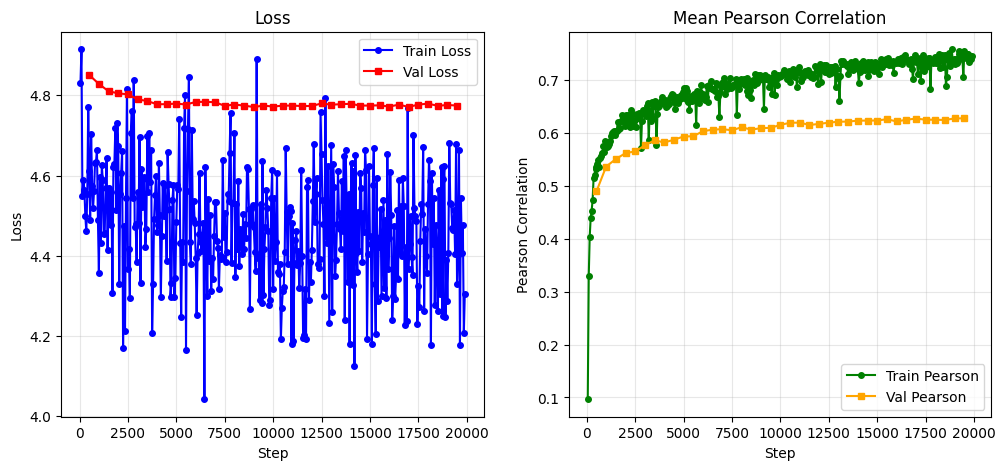

In [22]:
# Plot training results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df_train = pd.read_csv("metrics_train.csv")
df_val = pd.read_csv("metrics_val.csv")

# Plot Loss
axes[0].plot(df_train["step"], df_train["mean_loss"], 'b-o', label='Train Loss', markersize=4, linewidth=1.5)
axes[0].plot(df_val["step"], df_val["mean_loss"], 'r-s', label='Val Loss', markersize=4, linewidth=1.5)
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot Pearson Correlation
axes[1].plot(df_train["step"], df_train["mean_pearson"], 'g-o', label='Train Pearson', markersize=4, linewidth=1.5)
axes[1].plot(df_val["step"], df_val["mean_pearson"], 'orange', marker='s', label='Val Pearson', markersize=4, linewidth=1.5)
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Pearson Correlation')
axes[1].set_title('Mean Pearson Correlation')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 9. 🧪 Test evaluation

Evaluate the fine-tuned model on the held-out test set to assess final performance. This provides an unbiased estimate of how well the model generalizes to unseen genomic regions.

In [ ]:
# Calculate number of test steps (based on deepspeed pipeline)
num_test_samples = len(test_dataset)
num_test_steps = num_test_samples // config["mini_batch_size"]
print(f"Running test evaluation with {num_test_steps} steps ({num_test_samples} samples)")

# Load the best model checkpoint
model.load_state_dict(torch.load(config["best_model_checkpoint_path"]))
model.to(device)
print(f"Loaded model from {config['best_model_checkpoint_path']=!s}")

# Set model to eval mode
model.eval()

# Run test evaluation with progress bar
for test_batch in tqdm(test_loader, desc="Test evaluation", total=num_test_steps):        
    validation_step(        
        model, 
        test_batch, 
        test_metrics,
    )
    
# Compute final test metrics
test_metrics_dict = test_metrics.compute()
print("\n" + "="*50)
print("Test Set Results")
print("="*50)
print(f"\nMetrics:")
print(f"  Mean Pearson: {test_metrics_dict['mean/pearson']:.4f}")
for track_name in bigwig_ids:    
    print(f"    {track_name}/pearson: {test_metrics_dict[f'{track_name}/pearson']:.4f}")

## Test set results obtained for reference (human)

===== Test Set Results =====

Metrics:
Mean Pearson: 0.6050
- ENCSR154HRN_M/pearson: 0.5132
- ENCSR154HRN_P/pearson: 0.5095
- ENCSR935RNW_P/pearson: 0.5690
- ENCSR114HGS_M/pearson: 0.3433
- ENCSR487QSB/pearson: 0.7101
- ENCSR046BCI_M/pearson: 0.5188
- ENCSR100LIJ_M/pearson: 0.5632
- ENCSR754DRC/pearson: 0.6046
- ENCSR682BFG/pearson: 0.6839
- ENCSR862QCH_M/pearson: 0.5441
- ENCSR046BCI_P/pearson: 0.4872
- ENCSR249ROI_M/pearson: 0.6077
- ENCSR484LTQ_P/pearson: 0.4738
- ENCSR410DWV/pearson: 0.7949
- ENCSR619DQO_P/pearson: 0.6981
- ENCSR321PWZ_M/pearson: 0.6895
- ENCSR962OTG/pearson: 0.9150
- ENCSR321PWZ_P/pearson: 0.6903
- ENCSR484LTQ_M/pearson: 0.4812
- ENCSR628PLS/pearson: 0.6479
- ENCSR249ROI_P/pearson: 0.5761
- ENCSR799DGV_P/pearson: 0.5704
- ENCSR862QCH_P/pearson: 0.5402
- ENCSR527JGN_M/pearson: 0.5144
- ENCSR619DQO_M/pearson: 0.6975
- ENCSR814RGG/pearson: 0.7958
- ENCSR935RNW_M/pearson: 0.5600
- ENCSR863PSM/pearson: 0.6915
- ENCSR114HGS_P/pearson: 0.3447
- ENCSR325NFE/pearson: 0.8314
- ENCSR701YIC/pearson: 0.5613
- ENCSR527JGN_P/pearson: 0.7226
- ENCSR100LIJ_P/pearson: 0.5643

## Test set results obtained for a new species (tomato)

===== Test Set Results =====

Metrics:
Mean Pearson: 0.7596
- SRX29291439/pearson: 0.8581
- SRX27799718/pearson: 0.4512
- SRX29291446/pearson: 0.9152
- SRX29291430/pearson: 0.9069
- SRX27799731/pearson: 0.5254
- SRX27799719/pearson: 0.4435
- SRX29291442/pearson: 0.9151
- SRX27799733/pearson: 0.4725
- SRX27799722/pearson: 0.4795
- SRX29291444/pearson: 0.9139
- SRX29291440/pearson: 0.8633
- SRX27799727/pearson: 0.6209
- SRX29291438/pearson: 0.8770
- SRX27799703/pearson: 0.4722
- SRX29291448/pearson: 0.9160
- SRX29291441/pearson: 0.9169
- SRX29291447/pearson: 0.9171
- SRX29291445/pearson: 0.8990
- SRX29291431/pearson: 0.9181
- SRX29291443/pearson: 0.9103

NOTE: to achieve these results, set the 'species_name' to 'tomato' in the config.